# Use the GitHub API to visualize project contributions

In [3]:
import pandas
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [4]:
def query(format_url, **kwargs):
    url = format_url.format(**kwargs)
    response = requests.get(url)
    obj = response.json()
    df = pandas.DataFrame(obj)
    return df

def concat_queries(format_url, kwargs_list):
    dfs = list()
    for kwargs in kwargs_list:
        df = query(format_url, **kwargs)
        for key, value in kwargs.items():
            df[key] = value
        dfs.append(df)
    return pandas.concat(dfs)

In [5]:
repo_df = query('https://api.github.com/orgs/cognoma/repos')
repo_df.name.tolist()

['cognoma',
 'core-service',
 'task-service',
 'cancer-data',
 'machine-learning',
 'sandbox',
 'frontend',
 'cognoma.github.io',
 'uiux']

In [6]:
format_url = 'https://api.github.com/repos/cognoma/{repo_name}/contributors'
kwargs_list = [{'repo_name': repo} for repo in repo_df.name]
contrib_df = concat_queries(format_url, kwargs_list)

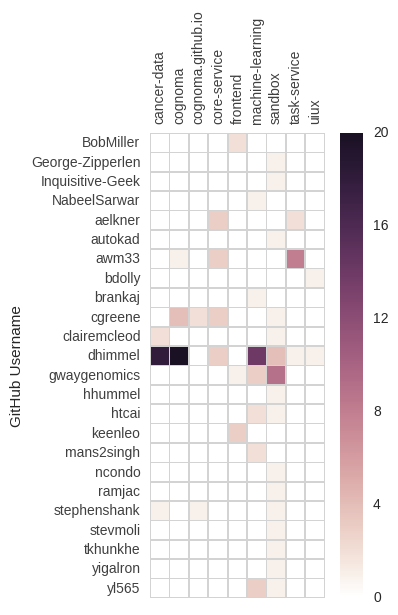

In [11]:
contrib_plot_df = (contrib_df
    #.query("repo_name != 'sandbox'")
    .pivot_table('contributions', 'login', 'repo_name', fill_value=0)
)
cmap = seaborn.cubehelix_palette(light=1, as_cmap=True, gamma=1.3)
ax = seaborn.heatmap(contrib_plot_df, square=True, linewidths=0.5, cmap=cmap, linecolor='#d3d3d3')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90, color='#3f3f3f')
plt.yticks(color='#3f3f3f')
plt.xlabel('')
plt.ylabel("GitHub Username")
fig = ax.get_figure()
fig.set_size_inches(w=4, h=6)
fig.savefig('contribution-heatmap.png', dpi=200, bbox_inches='tight')
fig.savefig('contribution-heatmap.svg', bbox_inches='tight')

In [13]:
pandas.show_versions()

/home/dhimmel/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



INSTALLED VERSIONS
------------------
commit: None
python: 3.5.2.final.0
python-bits: 64
OS: Linux
OS-release: 4.4.0-34-generic
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8

pandas: 0.18.1
nose: 1.3.7
pip: 8.1.2
setuptools: 26.1.1
Cython: 0.24.1
numpy: 1.11.1
scipy: 0.18.0
statsmodels: 0.6.1
xarray: None
IPython: 5.1.0
sphinx: 1.4.1
patsy: 0.4.1
dateutil: 2.5.3
pytz: 2016.6.1
blosc: None
bottleneck: 1.1.0
tables: 3.2.3.1
numexpr: 2.6.1
matplotlib: 1.5.1
openpyxl: 2.3.2
xlrd: 1.0.0
xlwt: 1.1.2
xlsxwriter: 0.9.2
lxml: 3.6.4
bs4: 4.5.1
html5lib: None
httplib2: None
apiclient: None
sqlalchemy: 1.0.13
pymysql: None
psycopg2: None
jinja2: 2.8
boto: 2.40.0
pandas_datareader: None
